In [1]:
# import Biopython functions
from Bio import SeqIO

# Loading sequences

In [2]:
# load the whole transcipt
transcript = next(SeqIO.parse("ncbi/complete.fasta", "fasta"))

# load the coding sequence
coding = next(SeqIO.parse("ncbi/coding.fasta", "fasta"))

In [3]:
print("Lenth of gene:", len(transcript.seq))
print("Lenth of coding sequence:", len(coding.seq))

Lenth of gene: 169451
Lenth of coding sequence: 9429


# Get cDNA
**cDNA** - *complementary* DNA

In [4]:
cDna = transcript.seq.complement()
cDna

Seq('AACGACACACTCCGTCTTGGACGCCCCCGTCCCCGCCCGACCAAGGGACCGGTC...AGT', SingleLetterAlphabet())

In [5]:
#save -f output/cDNA str(_)

# Transcription and translation

In [6]:
mRna = coding.seq.transcribe()
mRna

Seq('AUGGCGACCCUGGAAAAGCUGAUGAAGGCCUUCGAGUCCCUCAAGUCCUUCCAG...UGA', RNAAlphabet())

In [7]:
#save -f output/mRNA str(_)

In [8]:
translation = coding.seq.translate()
translation

Seq('MATLEKLMKAFESLKSFQQQQQQQQQQQQQQQQQQQQQPPPPPPPPPPPQLPQP...TC*', HasStopCodon(ExtendedIUPACProtein(), '*'))

In [9]:
#save -f output/translation str(_)

# Codons being used

In [10]:
seen = set()

for i in range(0, len(mRna) - 2, 3):
    codon = str(mRna[i:i+3])

    if codon not in seen:
        seen.add(codon)

print(len(seen), 'codons have been seen:')
print(sorted(seen))

62 codons have been seen:
['AAA', 'AAC', 'AAG', 'AAU', 'ACA', 'ACC', 'ACG', 'ACU', 'AGA', 'AGC', 'AGG', 'AGU', 'AUA', 'AUC', 'AUG', 'AUU', 'CAA', 'CAC', 'CAG', 'CAU', 'CCA', 'CCC', 'CCG', 'CCU', 'CGA', 'CGC', 'CGG', 'CGU', 'CUA', 'CUC', 'CUG', 'CUU', 'GAA', 'GAC', 'GAG', 'GAU', 'GCA', 'GCC', 'GCG', 'GCU', 'GGA', 'GGC', 'GGG', 'GGU', 'GUA', 'GUC', 'GUG', 'GUU', 'UAC', 'UAU', 'UCA', 'UCC', 'UCG', 'UCU', 'UGA', 'UGC', 'UGG', 'UGU', 'UUA', 'UUC', 'UUG', 'UUU']


# Amino acids histogram

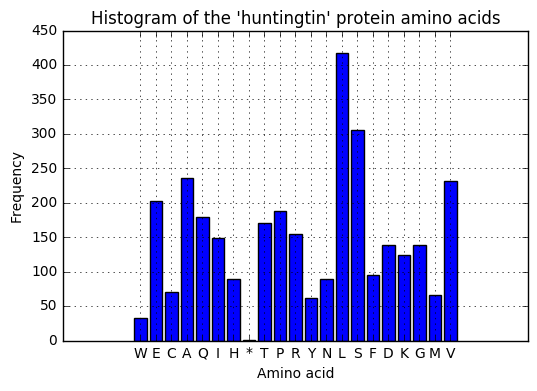

Counter({'L': 418, 'S': 306, 'A': 236, 'V': 232, 'E': 203, 'P': 188, 'Q': 180, 'T': 170, 'R': 154, 'I': 149, 'D': 139, 'G': 139, 'K': 124, 'F': 95, 'N': 90, 'H': 89, 'C': 70, 'M': 66, 'Y': 62, 'W': 32, '*': 1})


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# generate histogram
aa_hist = Counter(translation)
counts = aa_hist.values()
aas = aa_hist.keys()

# graph data
bar_x_locations = np.arange(len(counts))
plt.bar(bar_x_locations, counts, align = 'center')
plt.xticks(bar_x_locations, aas)

plt.title('Histogram of the \'huntingtin\' protein amino acids')
plt.xlabel('Amino acid')
plt.ylabel('Frequency')

plt.grid()
plt.show()

print(aa_hist)

# Usage of Leucine amino acids

In [12]:
leucineCodons = ['UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG']

for codon in leucineCodons:
    print(codon, mRna.count(codon), sep=': ')

UUA: 70
UUG: 156
CUU: 168
CUC: 178
CUA: 68
CUG: 295
